# Проект -13. Определение возраста по фото

# 1. Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# грузим датасет, смотрим на размер
labels=pd.read_csv('/datasets/faces/labels.csv')
labels.shape

(7591, 2)

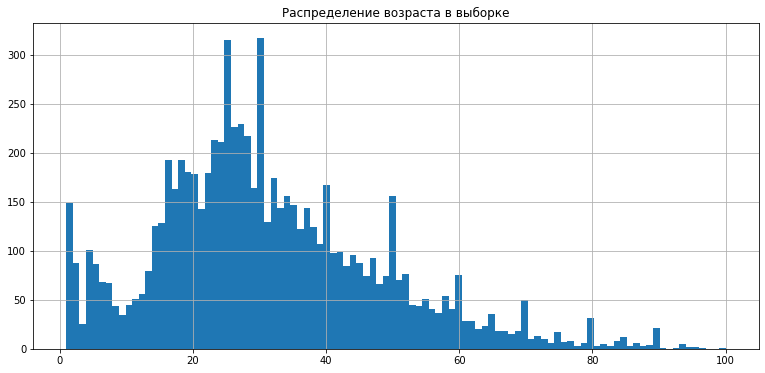

In [3]:
# гистограмма распределния возраста
plt.figure(figsize=(13,6))
ax=plt.hist(labels['real_age'], bins=100)
plt.grid()
plt.title('Распределение возраста в выборке')
plt.show()

In [4]:
# создаём генератор
datagen = ImageDataGenerator(rescale=1./255)

train_datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=112211)

Found 7591 validated image filenames.


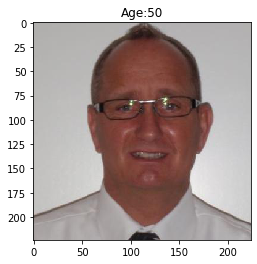

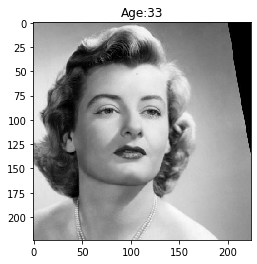

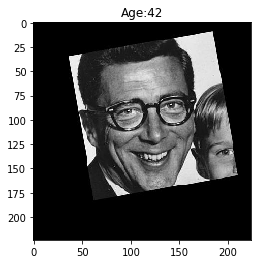

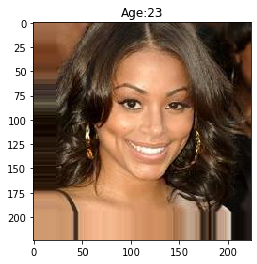

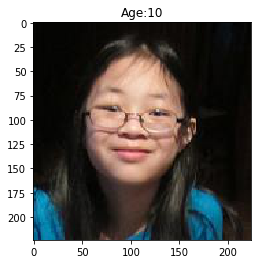

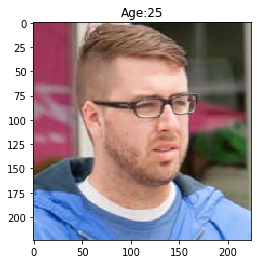

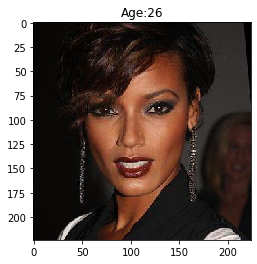

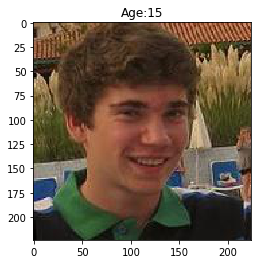

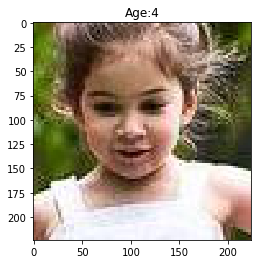

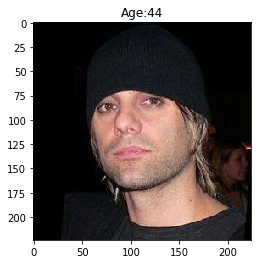

In [5]:
# посмотрим на первые 10 картинок
features, labels = next(train_datagen_flow)
for i in range(10):
    plt.imshow(features[i])
    plt.title('Age:{}'.format(labels[i]))
    plt.show()

### Выводы:
Имеем датасет из 7591 фото людей с метками об их возрасте.

Большинство людей на фото в возрасте от 18 до 35 лет. Так же есть большая группа детей (до 10 лет).

По фото можно сказать, что:
* Есть фотографии плохого качества
* Есть ч\б фото
* Есть фото с фоном, есть без

В целом, фото выровняны лицом по центру, что хорошо для наших целей. Никаких аугментаций делать не будем.

# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.

Будем использовать ResNet50 в качестве базы модели, на выходе лишь добавим один нейрон с активацией ReLU. 

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
 
 
def load_train(path):
    
    labels=pd.read_csv('/datasets/faces/labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        # указываем, что это загрузчик для обучающей выборки
        subset='training',
        seed=112211)
 
    return train_datagen_flow

def load_test(path):
    
    labels=pd.read_csv('/datasets/faces/labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        # указываем, что это загрузчик для тестовой выборки
        subset='validation',
        seed=112211)
 
    return test_datagen_flow 
 
def create_model(input_shape):
 
    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 190 steps, validate for 48 steps
Epoch 1/10
190/190 - 136s - loss: 200.5323 - mae: 10.5304 - val_loss: 354.2199 - val_mae: 14.0528
Epoch 2/10
190/190 - 43s - loss: 100.8092 - mae: 7.6255 - val_loss: 420.0381 - val_mae: 15.4553
Epoch 3/10
190/190 - 43s - loss: 66.5513 - mae: 6.2134 - val_loss: 417.4764 - val_mae: 15.4688
Epoch 4/10
190/190 - 42s - loss: 40.0489 - mae: 4.8832 - val_loss: 183.1694 - val_mae: 10.1882
Epoch 5/10
190/190 - 43s - loss: 30.8025 - mae: 4.3008 - val_loss: 126.0457 - val_mae: 8.7768
Epoch 6/10
190/190 - 43s - loss: 20.3433 - mae: 3.4762 - val_loss: 87.9306 - val_mae: 7.2177
Epoch 7/10
190/190 - 43s - loss: 16.5361 - mae: 3.1374 - val_loss: 87.4197 - val_mae: 6.9971
Epoch 8/10
190/190 - 43s - loss: 13.3379 - mae: 2.8232 - val_loss: 91.1517 - val_mae: 7.4208
Epoch 9/10
190/190 - 43s - loss: 10.9211 - mae: 2.5505 - val_loss: 81.0569 - val_mae: 6.7163
Epoch 10/10
190/190 - 43s - loss: 9.2673 - mae: 2.3326 - val_loss: 77.7254 - val_mae: 6.7960

48/48 - 9s - loss: 77.7254 - mae: 6.7960
Test MAE: 6.7960

```

# 3. Анализ обученной модели

В качестве модели для обучения использовалась ResNet50, предобученная на ImageNet. К модели был добавлен один выходной слой, с функцией активации Relu. </br>
Функция потерь - MSE. Контролируемая метрика - MAE. Оптимизатор - ADAM (lr=0.0005) </br>
Для валидации модели использовалась выборка в 20% от исходного датасета.

За 10 эпох обучения модели(размер батча 32), удалось достичь MAE=6.7960. Что в целом говорит о неплохом результате!